# Abstract


In this AI project, we propose a deep learning model that predicts the exact target location through the Time Difference Of Arrival for each location measurement sensor in an environment where there are indoor obstacles and errors. The deep learning model we envisioned proceeds in the following order. Errors that may occur due to internal obstacles are reflected in the TDOA measurement value for each sensor. TDOA data with errors reflected is converted into TDOA images. A TDOA image consists of the probabilities of a hyperbola graph passing through each image grid. Train a CNN model with fully connected layers to estimate target positions via backpropagation by accumulating and processing TDOA images as input data. We compared the performance of a model using CNN and a simple learning model and examined where our results can be applied in real life.



# Introduction 


With the development of IT technology, unmanned systems are gradually being used in many fields. In particular, in unmanned stores for example Amazon Go, when a customer puts items in a shopping cart and goes straight to the exit without a checkout process, the product that are purchased are identified and payment is automatically made. This technology is possible because many sensors and cameras in the store can determine what products a customer has in their shopping cart.

However, these sensors and cameras are expensive to purchase and for operate. In order to reduce cost, Recent preliminary studies have tried to obtain accurate TDOA through several algorithms, especially deep learning.

Several studies that use deep-learning, TDOA for location , method simply inferred the correct TDOA value and tracked the location using the hyperbolic equation, and did not use deep learning for the entire process. In addition, the method of estimating the position through TDOA is essential to find the intersection of the hyperbolic equations, but this process needs a lot of computer resources to solve these complex nonlinear equations. 

Therefore, to solve these problems, we will build a deep lear:ning model that estimates the exact coordinates of the target by using the TDOA values extracted from the rough space. In particular, we will build a CNN model by converting each TDOA measurement into a TDOA image. We expect that it will be possible to accurately and quickly determine the location of the target even in complex spaces such as unmanned convenience stores and indoor gyms.


<img src='https://drive.google.com/uc?id=1TMMkuAUOBCZzD8MhjaiZyF6aXK7ZXfKB' width="400"> 
<img src='https://drive.google.com/uc?id=1TMdM__fzPziQVLQ3xDkhUgrxpKAwxh3z' width="400">

<Fig1. Amazon Go camera and sensors> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<Fig2. Estimate target coordinate by TDOA>



# Simulation architecture
1. Generate true target coordinate - ($y$)
2. Generate target coordinate from device - ($\hat{y}$)
3. Generate TOA data and apply noise and Frasnel zone distance and calculate TDOA
4. Convert TDOA data into TDOA image
5. Make CNN model
6. Create Output 

<img src='https://drive.google.com/uc?id=1iSyJAdws-qDoLC8H5hq-zk-Gy60onsg0' width="1200">


# Our codes

## Implement packages

In [ ]:
import os
import os.path as osp

import numpy as np

import random
import csv

import pandas as pd
import matplotlib.pyplot as plot
import math
from sklearn.model_selection import train_test_split
import seaborn as sns
import random

import tensorflow as tf
import tensorflow.keras as keras

## Hyperparameters 


In [ ]:
######################################################
# fix me
# Parameters for CNNs
CNN1_inputchannel = 3
CNN1_outchannel = 128 
CNN1_kernal = 2
CNN1_stride = 1

CNN2_outchannel = 256
CNN2_kernal = 2
CNN2_stride = 1

CNN3_outchannel = 256
CNN3_kernal = 2
CNN3_stride = 1

Pool_kernal = 2 # max pooling
Pool_stride = 2

num_epochs = 10
batch_size = 10

sensor_ref = [0,0]
sensor1 = [25,0]
sensor2 = [0,25]
sensor3 = [25,25]

world_size_x = 25
world_size_y = 25
grid_size = 0.25

epsilon = 0.01
probability_gap = 10
######################################################

# Overall procsees for creating train dataset

1. Create arbitraely X and Y target data between 0~25
    + Target data is made!
2. Apply random noise to arbitraely generated target data (hat data)
    + this is hat data that measured by device
    + X target data with noise is X_hat, Y target data with noise is Y_hat
3. Create distance between each sensor and hat data

4. Apply environmental error

5. Create TDOA between reference sensor and each sensor

6. Change TDOA to TDOA image


### Create arbitraely X and Y target data between 0~25


<img src='https://drive.google.com/uc?id=1TMCu_GfO0clZAngFK1pWDkqDCh19s_KH' width="400">


+ Sensor_ref = [0,0]
+ Sensor_1 = [25,0]
+ Sensor_2 = [0,25]
+ Sensor_3 = [25,25]

+ Target = [x,y] (0 <= x,y <= 25)



In [ ]:
MC_N = 10**4   # Number of total simulation
MC_N = int(MC_N * 2)

size_x = 25   # X axis size
size_y = 25   # Y axis size

X_x_list = np.random.rand(MC_N,1) * size_x    # Target X axis data that generated randomly between 0~25
X_x_list = X_x_list.flatten().tolist()
X_y_list = np.random.rand(MC_N,1) * size_y    # Target Y axis data that generated randomly between 0~25
X_y_list = X_y_list.flatten().tolist()

sensor_ref_x_list = [0] * MC_N                      #sensor ref x coordinate
sensor_ref_y_list = [0] * MC_N                      #sensor ref  y coordinate
sensor_one_x_list = [size_x] * MC_N                 #sensor 1 x coordinate
sensor_one_y_list = [0] * MC_N                      #sensor 1 y coordinate
sensor_two_x_list = [0] * MC_N                      #sensor 2 x coordinate
sensor_two_y_list = [size_y] * MC_N                 #sensor 2 y coordinate
sensor_three_x_list = [size_x] * MC_N                #sensor 3 x coordinate
sensor_three_y_list = [size_y] * MC_N                #sensor 3 y coordinate

### Example of a TDOA dataset created through an actual experiment.

<img src='https://drive.google.com/uc?id=1Wym8DdqfQuY4VSDFmxiogRXUl_ade25X' width="600">

### Apply random noise to arbitraely generated target data (hat data)

<img src='https://drive.google.com/uc?id=15mMsts3LDD5phNdvSHMTWZqrkpJ4FJ8t' width="600">

- Based on the interview data, we generated simulation space and $y_{hat}$ data.


 - We have real experimental data, but since the actual data is already parsed one, we thought that it was not suitable for creating a rough environment. So we decided to proceed with computer simulation.


 - We finding out the error range of **device** using the product specification of the tag used in the experiment.
 
- Error range was randomly applied similarly to the actual measurement value for simulation.

In [ ]:

max_device_error = 0.1  #위의 사진에 의해 device 기기의 에러값 선언

noise_x_list = []
noise_y_list = []


while(len(noise_x_list) != MC_N):
    #After generating a Gaussian standard normal distribution random number from mean 0 stdv 1,
    # multiplicate with max_device_error and scaled to the maximum error.
    temp_x = np.random.randn()  * max_device_error   
    temp_y = np.random.randn()  * max_device_error
    
    if( (temp_x**2 + temp_y**2 < max_device_error ** 2) ):    
        noise_x_list.append(temp_x)
        noise_y_list.append(temp_y)
    
    
X_hat_x_list = [x+y for x,y in zip(X_x_list, noise_x_list)]   # X coordinate generated from device
X_hat_y_list = [x+y for x,y in zip(X_y_list, noise_y_list)]   # Y coordinate generated from device

### Create distance between each sensor and hat data

In [ ]:
distance_ref_X_hat_list = [-100] * MC_N  
distance_one_X_hat_list = [-100] * MC_N  
distance_two_X_hat_list = [-100] * MC_N  
distance_three_X_hat_list = [-100] * MC_N  


for i in range(MC_N):
    X_x = X_x_list[i]
    X_y = X_y_list[i]
    
    X_hat_x = X_hat_x_list[i]
    X_hat_y = X_hat_y_list[i]
    
    sensor_ref_x = sensor_ref_x_list[i]
    sensor_ref_y = sensor_ref_y_list[i]
    sensor_one_x = sensor_one_x_list[i]
    sensor_one_y = sensor_one_y_list[i]
    sensor_two_x = sensor_two_x_list[i]
    sensor_two_y = sensor_two_y_list[i]
    sensor_three_x = sensor_three_x_list[i]
    sensor_three_y = sensor_three_y_list[i]
    
    
    distance_ref_X_hat_list[i] = math.sqrt((X_hat_x - sensor_ref_x)**2 + (X_hat_y - sensor_ref_y)**2)  # ref과 Xhat 거리
    distance_one_X_hat_list[i] = math.sqrt((X_hat_x - sensor_one_x)**2 + (X_hat_y - sensor_one_y)**2)  # 1과 Xhat 거리
    distance_two_X_hat_list[i] = math.sqrt((X_hat_x - sensor_two_x)**2 + (X_hat_y - sensor_two_y)**2)  # 2와 Xhat 거리
    distance_three_X_hat_list[i] = math.sqrt((X_hat_x - sensor_three_x)**2 + (X_hat_y - sensor_three_y)**2)  # 3과 타Xhat 거리


### Apply environmental error

+ Several ways to apply environmental error
    + 1. Just make 0 for errors [previous idea]
    + 2. Make random number for errors
    + 3. **Apply new distances using physics formulas for obstacles**

\
#### Apply physics fomula for obstacles - [Fresnel Zone]
+ The Fresnel area is used to analyze the effect of obstacles placed on the line-of-sight transmission path. 


<img src='https://drive.google.com/uc?id=1TM-d6j_zSnbp1VAGcn32ndew5wSkZ1-h' width="500">

+ Assuming there is an obstacle, the error rate is assumed to be 30%. \

+ If there is an obstacle, it is necessary to use a new distance affected by the obstacle rather than the straight distance between the transmitter and the receiver. \

+ Therefore, using Fresnel zone equation, after calculating a new distance, apply to our distance data.

#### Fresnel Equation

<img src='https://drive.google.com/uc?id=1TM8A-AtmkyGS50W36La9IpqiyFePRfjd' width="300">

+ while lambda is wavelength of electric wave
+ $d_1$ is distance between obstacle and transmitter
+ $d_2$ is distance between obstacle and receiver

So, applied distance result will be:
+ $\sqrt{{d_1}^2 + {A_1}^2} + \sqrt{{d_2}^2 + {A_1}^2}$

In [ ]:
df = pd.DataFrame(data = {'X_x':X_x_list , 'X_y' : X_y_list , 
                         'X_noise_x':noise_x_list , 'X_noise_y' : noise_y_list , 
                          'X_hat_x':X_hat_x_list ,'X_hat_y':X_hat_y_list,
                          'distance_ref_X_hat' : distance_ref_X_hat_list , 'distance_one_X_hat' : distance_one_X_hat_list,
                          'distance_two_X_hat' : distance_two_X_hat_list , 'distance_three_X_hat' : distance_three_X_hat_list   
                         })


def create_environment_error(distance):
    error_rate = 0.3
    if(float(np.random.rand()) < error_rate):
        obstacle_heigth =  3 * np.random.rand()   #부딪히는 물체의 길이
        if(distance < obstacle_heigth):         # 말이 안되는거 상황 0으로 채워 넣음
            return 0
        
        #By 프레넬 영역을 이용한 추가 이동 거리 구현(함 위에 사이트 읽어보고 이상하다 싶으면 바로 말해줘요)
        distance1 = np.random.randn() + (distance/2)
        distance2 = distance - distance1
        if(distance1 < 0 or distance2 < 0):     # 말이 안되는거 상황 0으로 채워 넣음
            return 0 
        
        Fresnel_a = 0.01 * math.sqrt(distance1 * distance2 / (distance1+distance2))

        break_n = 1
        while(Fresnel_a < obstacle_heigth):
            Fresnel_a = Fresnel_a * (break_n+1) / break_n
            break_n +=1
        
        distance_final = math.sqrt(np.square(distance1) + np.square(Fresnel_a)) + math.sqrt(np.square(distance2) + np.square(Fresnel_a))
        
        
    else:
        distance_final = distance

    return distance_final

df['error_distance_ref_X_hat'] = df['distance_ref_X_hat'].apply(create_environment_error)
df['error_distance_one_X_hat'] = df['distance_one_X_hat'].apply(create_environment_error)
df['error_distance_two_X_hat'] = df['distance_two_X_hat'].apply(create_environment_error)
df['error_distance_three_X_hat'] = df['distance_three_X_hat'].apply(create_environment_error)


### Create TDOA between reference sensor and each sensor

In [ ]:
df['TDOA_X_hat_ref_one_error'] = df['error_distance_ref_X_hat'] - df['error_distance_one_X_hat']
df['TDOA_X_hat_ref_two_error'] = df['error_distance_ref_X_hat'] - df['error_distance_two_X_hat']
df['TDOA_X_hat_ref_three_error'] = df['error_distance_ref_X_hat'] - df['error_distance_three_X_hat']

df_parsing = df[['TDOA_X_hat_ref_one_error' , 'TDOA_X_hat_ref_two_error' , 'TDOA_X_hat_ref_three_error' , 'X_x' , 'X_y']]
df_parsing.columns = ['TDOA_1', 'TDOA_2', 'TDOA_3' , 'coordinate_x' , 'coordinate_y']

df_parsing = df_parsing.reset_index(drop=True)

TDOA_X_ref_one_list = df_parsing['TDOA_1'].tolist()
TDOA_X_ref_two_list = df_parsing['TDOA_2'].tolist()
TDOA_X_ref_three_list = df_parsing['TDOA_3'].tolist()

TDOA_pair_ref = [(TDOA_X_ref_one_list[ii], TDOA_X_ref_two_list[ii], TDOA_X_ref_three_list[ii]) for ii in range(len(TDOA_X_ref_one_list))]

ylabel_ref = [(X_x_list[ii] / size_x, X_y_list[ii] / size_y ) for ii in range(len(X_x_list))] 

### Scaling for data 

In [ ]:
def ScalerCoordinate(value):   #world size = area's width and height , value =  x,y coordinate
    world_size = 25
    value = value / world_size
    return value


def ScalerTDOA(value):   #world size = area's width and height , value = TDOA value
    #world_size = 25 * 2**(0.5)
    world_size = 100  
    value = value / world_size
    return value


df = df_parsing

df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']] = df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']].apply(ScalerTDOA)  #길이에 대하여 스케일링
df[['coordinate_x' , 'coordinate_y']] = df[['coordinate_x' , 'coordinate_y']].apply(ScalerCoordinate)  #좌표에 대하여 스케일링

train_df , test_df = train_test_split(df, test_size = 0.2)

train_TDOAs = train_df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']].to_numpy()
train_X_Hats = train_df[['coordinate_x' , 'coordinate_y']].to_numpy()

test_TDOAs = test_df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']].to_numpy()
test_X_Hats = test_df[['coordinate_x' , 'coordinate_y']].to_numpy()

### Create TDOA Image from TDOA data

+ Reason why we use image data
1. Hyperbola is a non-linear equation, and the calculation cost needs to be simplified, not a joke.
2. High position uncertainty due to time subtraction operation to make TDOA
3. In a very robust environment, the TDOA error value correction algorithm does not work well. To solve this, other methods are needed instead of correcting the values!




#### Initial Idea:
+ Make TDOA image by transform TDOA hyperbola into grid world.
+ Each grid contains value of 0 or 1. 
+ value 1 means TDOA hyperbola passes grid, and 0 is not.

\
<img src='https://drive.google.com/uc?id=1TME89PaXmGiGE7kCSiAGq4ohkLRBcJSe' width="1000">

#### Modificated idea:
An image of the 'probability' that the hyperbolic equation will pass through the grid area

+ Make TDOA image by transform TDOA hyperbola into grid world.
+ Each grid contains value between 0 and 1. 
+ Each value means probability that TDOA hyperbola passes grid.
+ If grid value is close to 1, it means there are high probability that hyperbola passes.

+ If the difference between the TDOA value calculated by the center coordinates of each grid world and the TDOA value of the actual target is very small, we can predict that the target is in the grid world.
+ We can gradually decrease the probability by increasing the value of this epsilon.



<img src='https://drive.google.com/uc?id=1Hb-TvYikfaonQrfYqtqO5sIEBuuUd--y' width="1000">



In [ ]:

# TDOA image 생성 모듈 정의
# input: TDPA
# output: TDOA_images
  
def TDOA_image_generation(sensor1, sensor2, TDOA, world_size_x, world_size_y, grid_size, epsilon, probability_gap):
   
  center_x = np.linspace(0 , world_size_x , int(world_size_x / grid_size))  + 0.5*grid_size  # x길이 10에 그리드사이즈가 2로 가정했을때 해당 좌표의 중심 좌표는 1, 3, 5, 7, 9 => 이를 수학적으로 수열화 한거!
  center_y = np.linspace(world_size_y , 0 , int(world_size_x / grid_size))  + 0.5*grid_size  # 마찬가지
  cord_center_x, cord_center_y = np.meshgrid(center_x,center_y)  #이를 매트릭스화
  
  distance_matrix = np.sqrt((cord_center_x - sensor1[0])**2 + (cord_center_y - sensor1[1])**2) - np.sqrt((cord_center_x - sensor2[0])**2 + (cord_center_y - sensor2[1])**2)  # 그리드 사이즈 중심좌표로부터 센서간의 거리의 계산 차 (=중심 좌표의 TDOA)
  tdoa_distance = np.abs(distance_matrix - TDOA)  #실제 TDOA 값과 차이 계산

  # 예시 [[10.8,0.38]
  #        [7.679,12.6479]]

  tdoa_image =  tdoa_distance // epsilon  #앱실론의 몇배인지 계산하기 위해서 ex) 앱실론이 0.1 이고 거리차가 0.38이면 0이 되겠죠?
  tdoa_image[tdoa_image > probability_gap] = probability_gap  # 너무 차이나는 애들 통일 ex) 앱실론이 0.1이고 거리차가 15든 12이든 밑의 계산을 위해 10(probability)으로 통일
  
  tdoa_image = (probability_gap - tdoa_image) / probability_gap #( [[10,10]     -   [[10,0]]   ) / 10   =  [[0,1]
                                                                #   10,10]]         [7,10]                  [0.3,0]]

  return tdoa_image

In [ ]:
TDOA_images_ref = []
for ii in range(len(TDOA_pair_ref)):
    image1 = TDOA_image_generation(sensor_ref, sensor1, TDOA_pair_ref[ii][0], world_size_x, world_size_y, grid_size, epsilon, probability_gap)
    image2 = TDOA_image_generation(sensor_ref, sensor2, TDOA_pair_ref[ii][1], world_size_x, world_size_y, grid_size, epsilon, probability_gap)
    image3 = TDOA_image_generation(sensor_ref, sensor3, TDOA_pair_ref[ii][2], world_size_x, world_size_y, grid_size, epsilon, probability_gap)
    TDOA_images_ref.append((image1, image2, image3))
    if(len(TDOA_images_ref) % 1000 == 0):
      print(len(TDOA_images_ref))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


  #### Image size

- Since Grid_size is 0.25, image size is 100,100

In [ ]:
TDOA_sample = TDOA_pair_ref[0][0]
TDOA_sample_image = TDOA_image_generation(sensor_ref, sensor1, TDOA_sample, world_size_x, world_size_y, grid_size, epsilon, probability_gap)
TDOA_sample_image.shape

(100, 100)

### Split train and test set

In [ ]:
TDOA_images = TDOA_images_ref 
ylabels = ylabel_ref 

TDOA_images_val = TDOA_images[int(0.8*MC_N):]
TDOA_image_train = TDOA_images[:int(0.8*MC_N)]

ylabels_val = ylabels[int(0.8*MC_N):]
ylabels_train = ylabels[:int(0.8*MC_N)]

### Make model structure



In [ ]:
from keras import layers
from keras import models


model = models.Sequential() 
model.add(layers.Conv2D(CNN1_outchannel, (CNN1_kernal, CNN1_kernal), padding= "SAME",activation=layers.LeakyReLU(alpha=0.01), strides=CNN1_stride, 
                        input_shape= (CNN1_inputchannel, TDOA_sample_image.shape[0],TDOA_sample_image.shape[1]) ,kernel_initializer='he_normal'))
model.add(layers.MaxPool2D(pool_size=(Pool_kernal,Pool_kernal), strides= (Pool_stride, Pool_stride), padding = "SAME"  ) )

model.add(layers.Conv2D(CNN2_outchannel, (CNN2_kernal, CNN2_kernal), padding= "SAME" , activation=layers.LeakyReLU(alpha=0.01), strides=CNN2_stride ,kernel_initializer='he_normal'))
model.add(layers.MaxPool2D(pool_size=(Pool_kernal,Pool_kernal), strides=  (Pool_stride, Pool_stride), padding = "SAME"))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(CNN3_outchannel, (CNN3_kernal, CNN3_kernal), padding= "SAME" , activation=layers.LeakyReLU(alpha=0.01), strides=CNN3_stride ,kernel_initializer='he_normal'))
model.add(layers.MaxPool2D(pool_size=(Pool_kernal,Pool_kernal), strides=  (Pool_stride, Pool_stride), padding = "SAME")) 

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(256, activation='relu'))  
model.add(layers.Dense(2, activation=None))

In [ ]:
from tensorflow.keras.optimizers import Adam

save_loss = {}

model.summary()


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='mae', 
                              patience=5) 

model.compile(optimizer=Adam(learning_rate=1e-3),
        loss='MSE',
        metrics=['mae'])


history = model.fit(np.array(TDOA_image_train), np.array(ylabels_train),
                    epochs=num_epochs, batch_size=batch_size,verbose=1,
                     callbacks= [ earlystopping])

print('Finished Training')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 100, 128)       51328     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 50, 128)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 50, 256)        131328    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 25, 256)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 25, 256)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 25, 256)        2

[Text(0.5, 1.0, 'loss')]

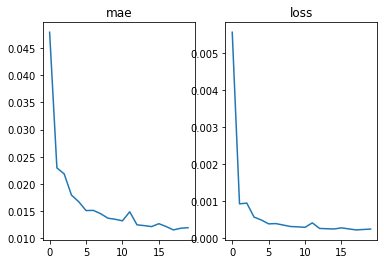

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

hist = history
fig,(ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, sharey = False)
ax0.plot(hist.history["mae"], label = 'mae')
ax0.set(title='mae')
ax1.plot(hist.history["loss"], label = 'loss')
ax1.set(title='loss')

In [ ]:
predict_X_Hats = model.predict(np.array(TDOA_images_val))

distance_gap = np.sqrt(np.sum(np.square(predict_X_Hats*25 - np.array(ylabels_val)*25), axis = 1))

mean_distance_gap = np.mean(distance_gap)
print('평균 오차 거리 : ' , np.round(mean_distance_gap,4) , '미터')

평균 오차 거리 :  0.4007 미터


In [ ]:
plt.hist(distance_gap, bins=20)
plt.xlim(0,10)
plt.xticks(range(0,11,1))
plt.show()


  <img src='https://drive.google.com/uc?id=1TRRt2YHofQiDwstmSEIkLiWsmK2EKut5' width="350">

# Results

### 1. Grid size really matters. 

The smaller the grid size, the more data for model input become more complex but the result is better. (Tradeoff between computational time and error)

< For grid_size = 1>

<img src='https://drive.google.com/uc?id=1TOz4y_V3nlOJZOyQVXCMRR7hfQhtSV-J' width="350">

< For grid_size = 0.5>

<img src='https://drive.google.com/uc?id=1TPEyYMEnw373MX247bg8uNxfVx038zNt' width="300">


### 2. Probability_gap and Epsilon must change relation to Grid size 

If the value grid size changes, the hyperparameters must be modified accordingly.In the process, the following facts were additionally discovered.



*   The probability gap is not unconditionally good because it is large unlike the grid size.
*   Most of the epsilon values showed good performance when values slightly smaller than (gridsize / probability_gap * 2).



### 3. Comparing with reference paper [Nitsoo et al., 2018]

<img src='https://drive.google.com/uc?id=1TPrf8VJXT4FzvFmAspuF8G5nIhLNfFix' width="600">


  <img src='https://drive.google.com/uc?id=1TQu6JWMw4gs6nN97aX13zp1oFusLRFN_' width="600">

  In our reference paper, coverage area is 13m x 20m, 
  \
   MAE is 0.3m~0.8m by various algorithms.

  Our coverage area is 25m x 25m and MAE for CNN model is 0.4m
  \
  If we consider large coverage area compare and error rate, our result is quite **meaningful** even considering that the environment is a little different.




## 3. FCNN (Fully connected Neural Network) Result

In [ ]:
# Do not modify this block
from tensorflow.keras import models
from tensorflow.keras import layers

model2 = models.Sequential()
model2.add(layers.Dense(25, activation='relu', input_shape=(3,)))
model2.add(layers.Dense(20, activation='relu'))
model2.add(layers.Dense(2))
model2.compile(optimizer='adam', loss='mse', metrics=['mae'])

num_epochs = 4

history = model2.fit(train_TDOAs, 
                      train_X_Hats,
                      epochs=num_epochs,
                      batch_size=batch_size, 
                      verbose=1)

Epoch 1/4
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0156 - mae: 0.0483
Epoch 2/4
1000/1000 [==============================] - 2s 2ms/step - loss: 2.6139e-04 - mae: 0.0129
Epoch 3/4
1000/1000 [==============================] - 2s 2ms/step - loss: 2.4230e-04 - mae: 0.0123
Epoch 4/4
1000/1000 [==============================] - 2s 2ms/step - loss: 2.1902e-04 - mae: 0.0116


[Text(0.5, 1.0, 'loss')]

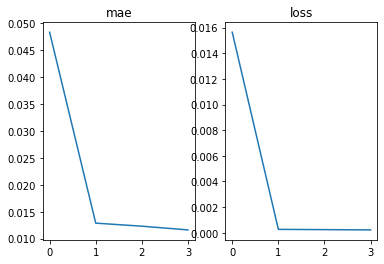

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

hist = history
fig,(ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, sharey = False)
ax0.plot(hist.history["mae"], label = 'mae')
ax0.set(title='mae')
ax1.plot(hist.history["loss"], label = 'loss')
ax1.set(title='loss')

In [ ]:
predict_X_Hats = model2.predict(test_TDOAs)

distance_gap = np.sqrt(np.sum(np.square(predict_X_Hats*25 - test_X_Hats*25), axis = 1))

mean_distance_gap = np.mean(distance_gap)
print('평균 오차 거리 : ' , np.round(mean_distance_gap,4) , '미터')

평균 오차 거리 :  0.4521 미터


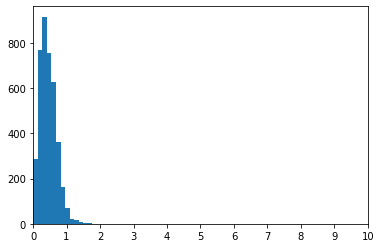

In [ ]:
plt.hist(distance_gap, bins=20)
plt.xlim(0,10)
plt.xticks(range(0,11,1))
plt.show()

Compare with simple FCNN model, its result is quite acceptable.
It needs less computational resource but its difference of error is quite low.

However, we need to think about error term. We applied Fresnel equation only 1 time for 30% ratio. In **real world**, it is not. It has **much more obstacles and effect of electric wave of obstacles are much more complicated**. So in this environment that has only 1 obstacles, its differences are not significant, but if we apply more complicated world, **CNN will show better result**.

## 4. Real life application

In introduction, we used Amazon Go as an example. However, Amazon go needs very low error of target tracking. 0.4M error is not applicable for Amazon go case. So we thought about other applications for this location tracking.

\
#### **1. Indoor Navigation**

For finding indoor route, some errors are acceptable. 

<img src='https://drive.google.com/uc?id=1TRHqa9oD8qeV2Lv8-EFdkPoz-_GZS7Vf' width="200">

#### **2. Gym tracking**

When you exercise, you can record what kind of exercise you did for how many minutes by synchronizing it with location information without having to record it separately.

\
#### **3. Location tracking in emergency.**

It can be usefully used in case of emergency such as fire. It can help rescue people by figuring out the target location in a situation where visibility is not secured.

<img src='https://drive.google.com/uc?id=1TRIrHuMJrICivTVj7JruFnJiFO2iiiWX' width="500">

## 5. Future Research 

**Mask Generation** : Although deep learning model can learn the value of mask by itself through analyzing correlation of TDOA measurements, we simply adopt the fixed value of mask, and more studies will be conducted in our future work.

# References

1. NIITSOO, Arne; EDELHÄUΒER, Thorsten; MUTSCHLER, Christopher. Convolutional neural networks for position estimation in tdoa-based locating systems. In: 2018 International Conference on Indoor Positioning and Indoor Navigation (IPIN). IEEE, 2018. p. 1-8.

2. XUE, Yuan, et al. DeepTAL: Deep learning for TDOA-based asynchronous localization security with measurement error and missing data. IEEE Access, 2019, 7: 122492-122502.

3. J. Baek, J. Lee, Y. Han, H. Shim, and S. Im, “Grid-based target
estimation scheme for passive coherent location system,” in 2019 IEEE
90th Vehicular Technology Conference (VTC2019-Fall), 2019, pp. 1–5.

4. Baek, J., Lee, S., Lee, C., & Park, S. (2021, October). A Deep Learning Approach for Robust Target Tracking in a Cluttered Environment. In 2021 International Conference on Information and Communication Technology Convergence (ICTC) (pp. 1033-1035). IEEE.

5. http://preview.kyobobook.co.kr/epubPreviewPopup.jsp?type=web&barcode=480D130703480&search=Y

6. https://hyoukjang.github.io/vr/indoor-positioning/ips/2017/10/22/positional-tracking-101-2.html



# Roles

### Sung-ho : Team leader
- Create topic idea
- Make simulation environment
- Applied Fresnel equation
- Modify TDOA image

### Jaemin : Team mate
- Data collection, preprocessing
- Model implementation
- Presentation preparation

# Github

https://github.com/Jammjm/AI_TDOA